<a href="https://colab.research.google.com/github/MajdTaweel/cv-project-2/blob/main/detection_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imageai==2.1.5 pytesseract
!sudo apt install tesseract-ocr

     |████████████████████████████████| 184kB 13.1MB/s 
  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=983a92d32bbc22659f98eca8382003717d16e152376219644a3e4a0cc43070d7
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-oc

In [7]:
!mkdir models images out

mkdir: cannot create directory ‘models’: File exists
mkdir: cannot create directory ‘images’: File exists
mkdir: cannot create directory ‘out’: File exists


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/My\ Drive/PalestinePlateModels/*.h5 /content/models
!cp /content/drive/My\ Drive/PalestinePlateModels/*.json /content/json
drive.flush_and_unmount()

In [8]:
from imageai.Detection.Custom import CustomObjectDetection

detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath("/content/import/detection_model-ex-005--loss-0003.806.h5")
detector.setJsonPath("/content/import/json/detection_config.json")
detector.loadModel()

In [105]:
drive.mount('/content/drive')
!cp "/content/drive/My Drive/PalestinePlateDataSet/images/img00313.jpg" /content/images
drive.flush_and_unmount()

Mounted at /content/drive


In [106]:
imgname = 'img00313.jpg';
input_image = f'images/{imgname}'
out_path = f'out/{imgname}'
detections = detector.detectObjectsFromImage(input_image=input_image, output_image_path=out_path, minimum_percentage_probability=30)
for detection in detections:
    print(detection["name"], " : ", detection["percentage_probability"], " : ", detection["box_points"])

plate  :  77.70397663116455  :  [94, 377, 181, 413]


/usr/local/lib/python3.6/dist-packages/imageai/Detection/Custom/__init__.py:1234: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-x))


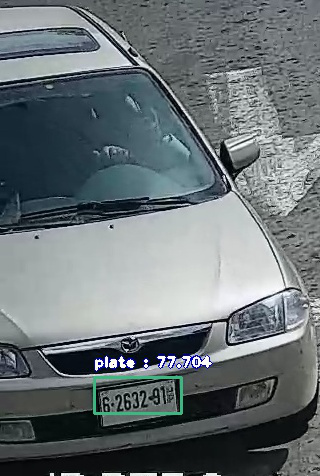

In [107]:
from PIL import Image
Image.open(out_path)

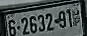

In [108]:
img = Image.open(input_image)
plate = img.crop(detections[0]["box_points"])

plate

In [109]:
imgname_noext = imgname.split('.')[0]
plate_path = f'out/{imgname_noext}-plate.jpg'
plate.save(plate_path)

In [111]:
import cv2
import numpy as np
import pytesseract

# get grayscale image
def get_grayscale(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
  return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
  return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
  kernel = np.ones((5,5),np.uint8)
  return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
  kernel = np.ones((5,5),np.uint8)
  return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
  kernel = np.ones((5,5),np.uint8)
  return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def closing(image):
  kernel = np.ones((2,2),np.uint8)
  return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=1)

#canny edge detection
def canny(image):
  return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
  coords = np.column_stack(np.where(image > 0))
  angle = cv2.minAreaRect(coords)[-1]
  if angle < -45:
    angle = -(90 + angle)
  else:
    angle = -angle
  (h, w) = image.shape[:2]
  center = (w // 2, h // 2)
  M = cv2.getRotationMatrix2D(center, angle, 1.0)
  rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
  return rotated

#template matching
def match_template(image, template):
  return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 



img = cv2.imread(plate_path)

gray = get_grayscale(img)
thresh = thresholding(gray)
close = closing(thresh)
# opening = opening(thresh)
# canny = canny(thresh)
deskew =  deskew(close)

cv2.imwrite("gray.jpg",gray)
cv2.imwrite("thresh.jpg",thresh)
cv2.imwrite("close.jpg",close)
# cv2.imwrite("opening.jpg",opening)
cv2.imwrite("deskew.jpg",deskew)
# cv2.imwrite("canny.jpg",canny)

custom_config = r'--oem 3 --psm 6 outputbase digits'

# alphanumeric = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
# custom_config = f'-c tessedit_char_whitelist={alphanumeric} --oem 3 --psm 6'
print(pytesseract.image_to_string(deskew, config=custom_config))

In [61]:
# import cv2 as cv
import pytesseract

# plateimg = cv.imread(plate_path)

# if plateimg.shape[2] >= 3:
#   plateimg = cv.cvtColor(plateimg, cv.COLOR_BGR2GRAY)

# custom_config = r'--oem 3 --psm 6'
custom_config = r'-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
text = pytesseract.image_to_string(plate, config=custom_config)
print(text)

# psm = 7
# alphanumeric = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
# options = f'-c tessedit_char_whitelist={alphanumeric} --psm {psm}'
# platetext = pytesseract.image_to_string(plateimg, config=options)

# platetext